In [190]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
import logging
import re
import pandapower as pp
import scipy
from scipy.sparse import csr_matrix
import pypsa
import geopandas as gpd
import pp_create_basic_network as basic
import matplotlib.pyplot as plt
import os


folder = '369_0'
zone='Midlands-Periurban'
MV_feeder = True
grid = "369_0"
scenario_year = 2050
weekday = "Friday"
day_start_ts = pd.to_datetime(f"{scenario_year}-01-07 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-01-08 00:00:00")
# month = day_start_ts.month
monitor_hr =int((day_end_ts - day_start_ts).total_seconds() / 3600)
path_uncontrolled = f"{grid}/{scenario_year}_{weekday}_01_07_uncontrolled_fix_v3"
path = '/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/modified_swiss_pdg/369_0/2050_01_07_uncontrolled_linear_acopf'
os.makedirs(path,exist_ok=True)
TP_dict = {1:2,2:2,3:2,4:3,5:3,6:4,7:4,8:4,9:4,10:3,11:2,12:1}
TP = TP_dict[day_start_ts.month] # 1:Dec, 2:Jan,Feb,Mar,Nov, 3:Apr,May,Oct, 4:Jun,Jul,Aug,Sep



def adjust_tap_pos(net):
    while (net.res_bus.vm_pu<0.97).any():
        i=0
        change_tap=False
        min_bus = net.res_bus.vm_pu.sort_values().index[i]
        while not change_tap:
            if (net.bus.loc[min_bus].vn_kv==0.4):
                match = re.search(r'^\d+-\d+_\d+_\d+', net.bus.loc[min_bus]['name'])
                lv_grid_id = match.group(0)
                trafo_id = net.trafo[net.trafo.name.str.contains(lv_grid_id)].index[0]
                if net.trafo.tap_pos.loc[trafo_id]>net.trafo.tap_min.loc[trafo_id]:
                    net.trafo.tap_pos.loc[trafo_id]-=1
                    change_tap=True
                else:
                    i+=1
            else:
                i+=1
        pp.runpp(net)
        if (net.trafo.tap_pos==net.trafo.tap_min).all():
            break
    return net


# net = basic.build_MV_LV_net('369_0')
# pp.runpp(net)
# net=adjust_tap_pos(net)
# base_load_profile = basic.prepare_base_profile(net,day_start_ts)
# hp_load_profile = basic.prepare_hp_profile(net,day_start_ts)
# pv_load_profile = basic.prepare_pv_profile(net,day_start_ts)
# ev_load_profile = basic.prepare_ev_profile(net,path_uncontrolled,grid,day_start_ts,monitor_hr,scenario_year)


# folder ='227-10_0_6'
# net = basic.build_LV_net(f'{folder}')
# base_load_profile = basic.prepare_base_profile(net,day_start_ts)
# hp_load_profile = basic.prepare_hp_profile(net,day_start_ts)
# pv_load_profile = basic.prepare_pv_profile(net,day_start_ts)
# ev_load_profile = basic.prepare_ev_profile(net,path_uncontrolled,grid,day_start_ts,monitor_hr,scenario_year)

net = pp.from_pickle(f'{path}/369_0.p')
base_load_profile = pd.read_pickle(f'{path}/369_0_base.pkl')
hp_load_profile=pd.read_pickle(f'{path}/369_0_hp.pkl')
pv_load_profile=pd.read_pickle(f'{path}/369_0_pv.pkl')
ev_load_profile=pd.read_pickle(f'{path}/369_0_ev.pkl')


# pp.to_pickle(net,f'{path}/369_0.p')
# base_load_profile.to_pickle(f'{path}/369_0_base.pkl')
# hp_load_profile.to_pickle(f'{path}/369_0_hp.pkl')
# pv_load_profile.to_pickle(f'{path}/369_0_pv.pkl')
# ev_load_profile.to_pickle(f'{path}/369_0_ev.pkl')


base_p = pd.DataFrame(base_load_profile.p_mw).T.apply(pd.Series.explode).reset_index(drop=True)
base_q = pd.DataFrame(base_load_profile.q_mvar).T.apply(pd.Series.explode).reset_index(drop=True)
hp_p = pd.DataFrame(hp_load_profile.p).T.apply(pd.Series.explode).reset_index(drop=True)
hp_q = pd.DataFrame(hp_load_profile.q).T.apply(pd.Series.explode).reset_index(drop=True)
pv_p = pd.DataFrame(pv_load_profile.pv_P_daily).T.apply(pd.Series.explode).reset_index(drop=True)
pv_q = pd.DataFrame(pv_load_profile.pv_Q_daily).T.apply(pd.Series.explode).reset_index(drop=True)
ev_p = pd.DataFrame(ev_load_profile.optimized_power_list).T.apply(pd.Series.explode).reset_index(drop=True)



In [191]:

try:
    pp.runpp(net)
except pp.LoadflowNotConverged:
    print("Load flow did not converge.")   
coo_Ybus = net._ppc["internal"]["Ybus"].tocoo()
Ybus_g_dict = {(i, j): v for i, j, v in zip(coo_Ybus.row, coo_Ybus.col, coo_Ybus.data.real)}
Ybus_b_dict = {(i, j): v for i, j, v in zip(coo_Ybus.row, coo_Ybus.col, coo_Ybus.data.imag)}

branch_data = net._ppc['branch']
fbus = branch_data[:,0].astype(int)
tbus = branch_data[:,1].astype(int)
branch_ft_bus_tuple = list(zip(fbus,tbus))

BRANCH_SMAX_trafo = dict(zip(list(zip(net.trafo.hv_bus,net.trafo.lv_bus)),net.trafo.sn_mva))
BRANCH_SMAX_line = dict(zip(list(zip(net.line.from_bus,net.line.to_bus)),net.line.parallel * net.line.max_i_ka * net.bus.loc[net.line.from_bus.values].vn_kv.values* np.sqrt(3))) 
BRANCH_SMAX_line.update(BRANCH_SMAX_trafo)
parallel_dict = dict(zip(list(zip(net.line.from_bus,net.line.to_bus)),net.line.parallel))

# Base Load Data
base_to_BUS_dict = base_load_profile.Bus.to_dict()
base_PD_coo = scipy.sparse.coo_matrix(np.array(base_load_profile.p_mw.tolist()))
base_PD_dict = {(base_to_BUS_dict[base],t):v for base, t, v in zip(base_PD_coo.row,base_PD_coo.col,base_PD_coo.data)}
base_QD_coo = scipy.sparse.coo_matrix(np.array(base_load_profile.q_mvar.tolist()))
base_QD_dict = {(base_to_BUS_dict[base],t):v for base, t, v in zip(base_QD_coo.row,base_QD_coo.col,base_QD_coo.data)}

# HP Data
HP_to_BUS_dict = hp_load_profile.Bus.to_dict()
hp_bus_tuple =[(HP,int(BUS)) for HP,BUS in  HP_to_BUS_dict.items()]
HP_max_dict = {}
HPQ_dict = {}
for hp, row in hp_load_profile.iterrows():
    bus = row['Bus']
    for t, p in enumerate(row['p']):
        HP_max_dict[(hp, bus, t)] = p
    for t, q in enumerate(row['q']):
        HPQ_dict[(hp,bus,t)] = q    

# PV data
PV_to_BUS_dict = pv_load_profile.Bus.to_dict()
pv_bus_tuple =[(PV,int(BUS)) for PV,BUS in  PV_to_BUS_dict.items()]
PV_Pmax_coo = scipy.sparse.coo_matrix(np.array(pv_load_profile.pv_P_daily.tolist())) # sparse matrix:row: pv index -> column: monitor_hr -> data: maximal PV power generation
PV_Pmax_dict = {(pv,int(PV_to_BUS_dict[pv]),t): v for pv, t, v in zip(PV_Pmax_coo.row, PV_Pmax_coo.col, PV_Pmax_coo.data)}
# PV_Qmax_dict = {(pv,int(PV_to_BUS_dict[pv]),t): v*np.tan(np.arccos(0.8)) for pv, t, v in zip(PV_Pmax_coo.row, PV_Pmax_coo.col, PV_Pmax_coo.data)}
# PV_Qmin_dict = {(pv,int(PV_to_BUS_dict[pv]),t): v*np.tan(np.arccos(-0.8)) for pv, t, v in zip(PV_Pmax_coo.row, PV_Pmax_coo.col, PV_Pmax_coo.data)} 

# EV Data
PARK_to_EVBAT_dict = ev_load_profile.person.to_dict() # key: parking event -> value: person
PARK_to_BUS_dict = ev_load_profile.Bus.to_dict() # key: parking event -> vlaue: bus_id
PARK_to_ENDIDX_dict = ev_load_profile.park_end_time_idx.to_dict() # key:parking event -> value: park_end_time_idx
PARK_to_ARRIDX_dict = ev_load_profile.arr_time_idx.to_dict() # key:parking event -> value: arr_time_idx
park_bus_tuple = [(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1),int(BUS)) for PARK,BUS in  PARK_to_BUS_dict.items()] # (Parking event person,arr_time_idx, park_end_time_idx, bus)

PARK_PD_coo = scipy.sparse.coo_matrix(ev_load_profile.optimized_power_list.tolist()) # sparse matrix:row: parking event -> column: monitor_hr -> data: origin charging power of battery in consumer system
PARK_PD_dict = {(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1),int(PARK_to_BUS_dict[PARK]), t): -v for PARK, t, v in zip(PARK_PD_coo.row, PARK_PD_coo.col, PARK_PD_coo.data)} # key:(parking event,perosn,arr_time_idx,park_end_time_idx, bus_id, monitor_hr) -> value: ev battery injectied power from grid's perspective

PARKHR_coo = scipy.sparse.coo_matrix(ev_load_profile.hourly_time_dict.tolist()) 
PARKHR_dict = {(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1), int(PARK_to_BUS_dict[PARK]),t):v/60 for PARK,t,v in zip(PARKHR_coo.row,PARKHR_coo.col,PARKHR_coo.data)} # key:(parking event,perosn,arr_time_idx,park_end_time_idx, bus_id, monitor_hr) -> value: parking duration in Hour for this hour

SOE_dayend_dict = (ev_load_profile[['person','day_end_soe']].groupby('person').last().day_end_soe/1e3).to_dict()

NEXT_E = ev_load_profile[f'next_travel_TP{TP}_consumption']/1e3
NEXT_E_dict =  {(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1),int(PARK_to_BUS_dict[PARK])):next_e for PARK,next_e in zip(NEXT_E.index,NEXT_E.values)}
NEXT_2E = ev_load_profile[f'next_travel_TP{TP}_consumption']/1e3
NEXT_2E_dict =  {(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1),int(PARK_to_BUS_dict[PARK])):next_2e for PARK,next_2e in zip(NEXT_2E.index,NEXT_2E.values)}
SOE_change = scipy.sparse.coo_matrix(np.array(ev_load_profile.SoE_change/1e3))
SOE_change_dict = {(PARK,int(PARK_to_EVBAT_dict[PARK]),max(PARK_to_ARRIDX_dict[PARK],0),min(int(PARK_to_ENDIDX_dict[PARK]),monitor_hr-1),int(PARK_to_BUS_dict[PARK])):max(0,soe_change) for PARK, soe_change in zip(SOE_change.col,SOE_change.data)}

FIRST_PARKING = ev_load_profile[ev_load_profile.parking_cnt==0]
SOE_init_dict = dict(zip(FIRST_PARKING['person'],FIRST_PARKING['augmented_SoE_bc']/1e3))
EVCAP_dict = dict(zip(FIRST_PARKING.person,FIRST_PARKING.B/1e3))

Load flow did not converge.


/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_70093/3875786628.py:10: ComplexWarning:

Casting complex values to real discards the imaginary part

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_70093/3875786628.py:11: ComplexWarning:

Casting complex values to real discards the imaginary part



In [192]:
m = pyo.ConcreteModel()

# bounds definition/initialization rules
def soe_init_rule(model, person,t):
    if t==0:
        return SOE_init_dict.get(person,0)
    else:
        return 0
def SOE_bound_rule(model, person, t):
    max_soe = FIRST_PARKING.loc[FIRST_PARKING.person == person, 'B'].values[0] / 1e3
    return (0, max_soe)
def PVGENP_bound_rule(model,pv,bus,t):
    return (0,PV_Pmax_dict.get((pv,bus,t),0))
def EVGENP_bound_rule(model,ev,person,arr_idx,end_idx,bus,t):
    if ev_load_profile.loc[ev].hourly_time_dict[t]<=0:
        return(0,0)
    else:
        chg_rate_MW=ev_load_profile.loc[ev]['chg rate']/1e3
        return (-chg_rate_MW,chg_rate_MW) 

# Const:
M=1e8
slack=net._ppc['internal']['ref'][0]
# Sets
m.BUS =  pyo.Set(initialize = net.bus.index.values) # Bus Set
# m.BUSPPC = pyo.Set(initialize = net._pd2ppc_lookups["bus"][net.bus.index.values]) # Internal Bus Set
m.BRANCH = pyo.Set(dimen=2,initialize=branch_ft_bus_tuple) # Branch Set including line and trafos [0]fbus,[1]tbus
m.EVBAT = pyo.Set(initialize=net.storage.person.unique()) # EV Set
m.HP = pyo.Set(dimen=2,initialize= hp_bus_tuple) # (HP, Bus) Set
m.PV = pyo.Set(dimen=2,initialize = pv_bus_tuple) # (PV, Bus) Set
m.PARK = pyo.Set(dimen=5,initialize=park_bus_tuple) # (Parking Event,EVBAT,Bus) Set
m.T = pyo.Set(initialize=range(monitor_hr))

# Variables
m.PEXTGENP = pyo.Var(m.T,within=pyo.Reals,initialize=0) # External Generator
m.PEXTGENQ = pyo.Var(m.T,within=pyo.Reals,initialize=0) # External Generator

m.DELTA_V = pyo.Var(m.BUS,m.T,within=pyo.Reals,initialize=0) # Bus voltage deviation from 1pu ,bounds=(-0.08,0.08)
m.ANG = pyo.Var(m.BUS,m.T,within=pyo.Reals,bounds=(-2*np.pi,2*np.pi),initialize=0) # Bus voltage angle
m.DELTA_V_slack = pyo.Var(m.BUS,m.T,within=pyo.NonNegativeReals,initialize=0)

m.PVGENP = pyo.Var(m.PV,m.T,within=pyo.NonNegativeReals,bounds=PVGENP_bound_rule,initialize=0)
m.PVGENQ = pyo.Var(m.PV,m.T,within=pyo.Reals,initialize=0)
m.EVGENP = pyo.Var(m.PARK,m.T,within=pyo.Reals,bounds=EVGENP_bound_rule,initialize=0)
m.PBRANCH = pyo.Var(m.BRANCH,m.T,within=pyo.Reals,initialize=0)
m.QBRANCH = pyo.Var(m.BRANCH,m.T,within=pyo.Reals,initialize=0)
m.BRANCH_slack = pyo.Var(m.BRANCH,within=pyo.NonNegativeReals,initialize=0)

m.SOE = pyo.Var(m.EVBAT,m.T,within=pyo.NonNegativeReals,initialize=soe_init_rule)  #bounds=SOE_bound_rule,
m.SOE_dayend_slack= pyo.Var(m.EVBAT,within=pyo.NonNegativeReals,initialize=0)
m.SOE_upper_slack = pyo.Var(m.EVBAT,m.T,within=pyo.NonNegativeReals,initialize=0)

m.FLEX = pyo.Var(m.PARK,m.T,within=pyo.NonNegativeReals,initialize=1) # Flexibility indicator
m.EVP_SHIFT_ABS = pyo.Var(m.PARK,m.T,within=pyo.NonNegativeReals,initialize=100000) # ABS(m.EVGEN-m.EVPPLAN)
m.BUFFER = pyo.Var(m.T,within=pyo.NonNegativeReals,initialize=0)

# Parameter
m.YBUSG = pyo.Param(m.BUS,m.BUS,initialize=Ybus_g_dict,default=0)
m.YBUSB = pyo.Param(m.BUS,m.BUS,initialize=Ybus_b_dict,default=0)
m.BRANCH_MAXS = pyo.Param(m.BRANCH,initialize=BRANCH_SMAX_line)

m.BUILDINGPD = pyo.Param(m.BUS,m.T,initialize=base_PD_dict,default=0)
m.BUILDINGQD = pyo.Param(m.BUS,m.T,initialize=base_QD_dict,default=0)
m.HPPD = pyo.Param(m.HP,m.T,initialize=HP_max_dict,default=0)
m.HPQD = pyo.Param(m.HP,m.T,initialize=HPQ_dict,default=0)

m.SOE_init = pyo.Param(m.EVBAT,initialize=SOE_init_dict)
m.EVCAP = pyo.Param(m.EVBAT,initialize=EVCAP_dict)
m.EVPPLAN = pyo.Param(m.PARK,m.T,initialize=PARK_PD_dict,default=0) # Grid Perspecitve, positive P means discharging the battery
m.PARKHR = pyo.Param(m.PARK,m.T,initialize=PARKHR_dict,default=0) # Parking Duration in Hour for each parking event
m.SOE_dayend = pyo.Param(m.EVBAT,initialize=SOE_dayend_dict)
m.NEXT_E = pyo.Param(m.PARK,initialize=NEXT_E_dict) # Next trip's energy consumpiton
m.SOE_change = pyo.Param(m.PARK,initialize=SOE_change_dict,default=0)

m.NEXT_E_slack = pyo.Var(m.PARK,within=pyo.NonNegativeReals,initialize=0)

def active_power_balance_rule(m,bus,t):
    gen_power = (
            sum(m.PVGENP[pv,bus,t] for pv,b in m.PV if b==bus) + 
            sum(m.EVGENP[park,ev,arr_idx,end_idx,bus,t] for park,ev,arr_idx,end_idx,b in m.PARK if b==bus)
            +(m.PEXTGENP[t] if bus==slack else 0)
        )
    load_power = m.BUILDINGPD[bus,t] + sum(m.HPPD[HP,b,t] for HP,b in m.HP if b==bus)
    net_power_injection = gen_power - load_power
    incoming_flow = sum(m.PBRANCH[i,j,t] for i, j in m.BRANCH if j==bus)
    outgoing_flow = sum(m.PBRANCH[i,j,t] for i, j in m.BRANCH if i==bus)
    return net_power_injection+incoming_flow-outgoing_flow==0
m.ActivePowerBalance = pyo.Constraint(m.BUS,m.T,rule=active_power_balance_rule)

def reactive_power_balance_rule(m,bus,t):
    gen_power = sum(m.PVGENQ[pv,bus,t] for pv,b in m.PV if b==bus) + (m.PEXTGENQ[t] if bus==slack else 0)
    load_power = m.BUILDINGQD[bus,t] + sum(m.HPQD[HP,b,t] for HP,b in m.HP if b==bus)
    net_power_injection = gen_power - load_power
    incoming_flow = sum(m.QBRANCH[i,j,t] for i, j in m.BRANCH if j==bus)
    outgoing_flow = sum(m.QBRANCH[i,j,t] for i, j in m.BRANCH if i==bus)
    return net_power_injection+incoming_flow-outgoing_flow==0
m.ReactivePowerBalance = pyo.Constraint(m.BUS,m.T,rule=reactive_power_balance_rule)

def voltage_upper_rule(m,bus,t):
    return m.DELTA_V[bus,t]<=0.1+m.DELTA_V_slack[bus,t]
m.VoltageUpper = pyo.Constraint(m.BUS,m.T,rule=voltage_upper_rule)

def voltage_lower_rule(m,bus,t):
    return m.DELTA_V[bus,t]>=-0.1-m.DELTA_V_slack[bus,t]
m.VoltageLower = pyo.Constraint(m.BUS,m.T,rule=voltage_lower_rule)

def slack_bus_ang_rule(m,t):
    return m.ANG[slack,t]==0
m.SlackBusAng = pyo.Constraint(m.T,rule=slack_bus_ang_rule)

# def slack_bus_v_rule(m,t):
#     return m.V[slack,t]==1
# m.SlackBusV = pyo.Constraint(m.T,rule=slack_bus_v_rule)

def PVGENQ_lower_rule(m,pv,bus,t):
    return m.PVGENQ[pv,bus,t]>=-np.tan(np.arccos(0.8)) * m.PVGENP[pv,bus,t]
m.PvQLower = pyo.Constraint(m.PV,m.T,rule=PVGENQ_lower_rule)

def PVGENQ_upper_rule(m,pv,bus,t):
    return m.PVGENQ[pv,bus,t]<=np.tan(np.arccos(0.8)) * m.PVGENP[pv,bus,t]
m.PvQUpper = pyo.Constraint(m.PV,m.T,rule=PVGENQ_upper_rule)
    
def active_branch_flow_rule(m,i,j,t):
    delta_ang = m.ANG[i,t]-m.ANG[j,t]
    return m.PBRANCH[i,j,t] == (m.DELTA_V[i,t]-m.DELTA_V[j,t])*m.YBUSG[i,j] - m.YBUSB[i,j]*delta_ang
m.ActiveBranchFlow = pyo.Constraint(m.BRANCH,m.T,rule=active_branch_flow_rule)

def reactive_branch_flow_rule(m,i,j,t):
    delta_ang = m.ANG[i,t]-m.ANG[j,t]
    return m.QBRANCH[i,j,t] == -(m.DELTA_V[i,t]-m.DELTA_V[j,t])*m.YBUSB[i,j] - m.YBUSG[i,j]*delta_ang
m.ReactiveBranchFlow = pyo.Constraint(m.BRANCH,m.T,rule=reactive_branch_flow_rule)

def line_flow_s_upper(m,i,j,t):
    return m.PBRANCH[i,j,t]**2+m.QBRANCH[i,j,t]**2<=(m.BRANCH_MAXS[i,j]+ m.BRANCH_slack[i,j])**2
m.BranchSLimitUpper = pyo.Constraint(m.BRANCH,m.T,rule=line_flow_s_upper)


def soe_agg_dynamic_rule(m,person,t):
    if t==0:
        return m.SOE[person,0]==m.SOE_init[person]
    else:
        return m.SOE[person,t] == (
                                m.SOE[person,t-1]
                                +sum(-m.EVGENP[park,ev,arr_idx,end_idx,bus,t-1]*m.PARKHR[park,ev,arr_idx,end_idx,bus,t-1] for park,ev,arr_idx,end_idx,bus in m.PARK if ev==person)
                                -sum(m.SOE_change[park,ev,arr_idx,end_idx,bus] for park,ev,arr_idx,end_idx,bus in m.PARK if (ev==person and t==arr_idx))
                            )
m.SoeAggDynamics = pyo.Constraint(m.EVBAT,m.T,rule=soe_agg_dynamic_rule)

def soe_upper_rule(m,person,t):
    return m.SOE[person,t]<=m.EVCAP[person]
m.SoeUpper = pyo.Constraint(m.EVBAT,m.T,rule=soe_upper_rule)


# def soe_next_trip_rule(m,park,ev,arr_idx,end_idx,bus,t):
#     """
#     ENFORCE THE NEXT TRIP'S ENERGY REQUIREMENT IS MET AT THE end_idx HOUR FOR EACH m.PARK
#     """
#     if end_idx==t-1 and arr_idx!=end_idx:
#         return m.SOE[ev,t]>=m.NEXT_E[park,ev,arr_idx,end_idx,bus]
#     else:
#         return pyo.Constraint.Skip
# m.SoeNextTrip = pyo.Constraint(m.PARK,m.T,rule=soe_next_trip_rule)

def soe_next_trip_rule(m,park,person,arr_idx,end_idx,bus,t):
    """
    ENFORCE THE NEXT TRIP'S ENERGY REQUIREMENT IS MET AT THE end_idx HOUR FOR EACH m.PARK
    """
    if end_idx==t and t<monitor_hr-1:
        return m.SOE[person,t]+sum(-m.EVGENP[park,person,arr_idx,end_idx,bus,t]*m.PARKHR[park,person,arr_idx,end_idx,bus,t] for park,p,arr_idx,end_idx,bus in m.PARK if p==person)>=m.NEXT_E[park,person,arr_idx,end_idx,bus]#+m.NEXT_E_slack[park,person,arr_idx,end_idx,bus]
    else:
        return pyo.Constraint.Skip  
m.SoeNextTrip = pyo.Constraint(m.PARK,m.T,rule=soe_next_trip_rule)


def differ_1(m,park,ev,arr_idx,end_idx,bus,t):
    return m.EVGENP[park,ev,arr_idx,end_idx,bus,t]-m.EVPPLAN[park,ev,arr_idx,end_idx,bus,t]<=M*m.FLEX[park,ev,arr_idx,end_idx,bus,t]
m.Differ1 = pyo.Constraint(m.PARK,m.T,rule=differ_1)

def differ_2(m,park,ev,arr_idx,end_idx,bus,t):
    return -m.EVGENP[park,ev,arr_idx,end_idx,bus,t]+m.EVPPLAN[park,ev,arr_idx,end_idx,bus,t]<=M*m.FLEX[park,ev,arr_idx,end_idx,bus,t]
m.Differ2 = pyo.Constraint(m.PARK,m.T,rule=differ_2)
# def evp_shift_rule_1(m,park,ev,arr_idx,end_idx,bus,t):
#     """
#     RULE 1 FOR GETTING ABSOLUTE EVGEN SHIFTED VALUE
#     """
#     return m.EVP_SHIFT_ABS[park,ev,arr_idx,end_idx,bus,t]>=m.EVGENP[park,ev,arr_idx,end_idx,bus,t]-m.EVPPLAN[park,ev,arr_idx,end_idx,bus,t]
# m.EVP_SHIFT_1 = pyo.Constraint(m.PARK,m.T,rule=evp_shift_rule_1)

# def evp_shift_rule_2(m,park,ev,arr_idx,end_idx,bus,t):
#     """
#     RULE 2 FOR GETTING ABSOLUTE EVGEN SHIFTED VALUE
#     """
#     return m.EVP_SHIFT_ABS[park,ev,arr_idx,end_idx,bus,t]>=-m.EVGENP[park,ev,arr_idx,end_idx,bus,t]+m.EVPPLAN[park,ev,arr_idx,end_idx,bus,t]
# m.EVP_SHIFT_2 = pyo.Constraint(m.PARK,m.T,rule=evp_shift_rule_2)

# def adjust_flex_rule(m,park,ev,arr_idx,end_idx,bus,t):
#     """
#     ENFORCE m.FLEX TO INDICATE IF THE EVGEN IS SHIFTED
#     """
#     return m.EVP_SHIFT_ABS[park,ev,arr_idx,end_idx,bus,t] <= M*m.FLEX[park,ev,arr_idx,end_idx,bus,t]
# m.ADJUST_FLEX = pyo.Constraint(m.PARK,m.T,rule=adjust_flex_rule)

# def flex_participation_limit_rule(m,t):
#     """
#     LIMIT FLEX NUMBER UNDER 30% OF ALL m.PARK AT EACH m.T
#     """
#     return sum(m.FLEX[park,ev,arr_idx,end_idx,bus,t] for park,ev,arr_idx,end_idx,bus in m.PARK)<=0.3*len(m.PARK)
# m.FLEX_LIMIT = pyo.Constraint(m.T,rule=flex_participation_limit_rule)

def day_end_soe_rule(m,person):
    """
    Make the SOE by the end of observaton period as close as possible to the originally planned SOE
    """
    return m.SOE_dayend[person] <= m.SOE[person,monitor_hr-1] + m.SOE_dayend_slack[person] 
m.DayEndSoe = pyo.Constraint(m.EVBAT,rule=day_end_soe_rule)


def objective_rule(m):
    return  sum(m.SOE_dayend_slack[person] for person in m.EVBAT)+sum(m.BRANCH_slack[i,j] for i,j in m.BRANCH) + sum(m.DELTA_V_slack[bus,t] for bus in m.BUS for t in m.T)
m.OBJ = pyo.Objective(rule=objective_rule,sense=pyo.minimize)


# Step 1: Set up logging configuration
logging.basicConfig(filename=f'./infeasible_constraints.log', 
                    level=logging.INFO, 
                    format='%(asctime)s %(levelname)s: %(message)s')

# Step 2: Define a custom function to log infeasible constraints
def log_infeasible_constraints_to_file(model):
    # Redirect output to a string
    from io import StringIO
    import sys
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    # Call the existing function to print infeasible constraints
    log_infeasible_constraints(model)
    # Restore stdout
    sys.stdout = old_stdout
    # Get the printed string
    infeasible_constraints_output = mystdout.getvalue()
    # Log the output
    logging.info(infeasible_constraints_output)


# Solve the model
solver = pyo.SolverFactory('gurobi')
results = solver.solve(m, tee=True)
print(results.solver.status)
log_infeasible_constraints_to_file(m)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19
Read LP format model from file /var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/tmp_bjk__jh.pyomo.lp
Reading time = 8.29 seconds
x1: 3520384 rows, 2984617 columns, 9061583 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D60)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3520384 rows, 2984617 columns and 9061583 nonzeros
Model fingerprint: 0x58eaea1e
Model has 197112 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 1e+08]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [3e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-08, 6e+00]
  RHS range        [4e-06, 1e-01]
  QRHS range       [2e-02, 3e+02]
Presolve removed 2321842 rows and 1824663 columns
Presolve time: 3.22s
Presolved: 1410821 rows, 1372233 columns, 4199135 nonzeros
Presolve

In [193]:
DELTA_V_slack = {(bus,t):0 if pyo.value(m.DELTA_V_slack[bus,t])<1e-8 else pyo.value(m.DELTA_V_slack[bus,t]) for bus in m.BUS for t in m.T}
branch_slack = {(i,j):0 if pyo.value(m.BRANCH_slack[i,j])<1e-8 else pyo.value(m.BRANCH_slack[i,j]) for (i,j) in m.BRANCH}

In [194]:
branch_slack

{(1, 2): 0,
 (2, 5): 0,
 (2, 6): 0,
 (3, 4): 0,
 (4, 5): 0,
 (6, 7): 0,
 (7, 29): 0,
 (8, 9): 0,
 (8, 10): 0,
 (8, 11): 0,
 (10, 30): 0,
 (10, 31): 0,
 (10, 32): 0,
 (11, 33): 0,
 (12, 13): 0,
 (12, 14): 0,
 (13, 34): 0,
 (15, 16): 0,
 (15, 17): 0,
 (16, 30): 0,
 (18, 19): 0,
 (18, 20): 0,
 (18, 21): 0,
 (19, 28): 0,
 (20, 35): 0,
 (20, 36): 0,
 (21, 37): 0,
 (22, 23): 0,
 (22, 24): 0,
 (23, 38): 0,
 (24, 39): 0,
 (25, 26): 0,
 (25, 27): 0,
 (26, 40): 0,
 (27, 41): 0,
 (28, 42): 0,
 (29, 31): 0,
 (30, 106): 0,
 (31, 104): 0,
 (31, 105): 0,
 (32, 107): 0,
 (34, 43): 0,
 (35, 143): 0,
 (37, 180): 0,
 (37, 178): 0,
 (38, 115): 0,
 (38, 112): 0,
 (39, 261): 0,
 (40, 144): 0,
 (41, 123): 0,
 (42, 43): 0,
 (44, 45): 0,
 (44, 46): 0,
 (45, 47): 0,
 (45, 48): 0,
 (46, 49): 0,
 (47, 50): 0,
 (49, 54): 0,
 (50, 68): 0,
 (50, 52): 0,
 (51, 52): 0,
 (51, 53): 0,
 (52, 69): 0,
 (54, 66): 0,
 (55, 56): 0,
 (55, 57): 0,
 (56, 63): 0,
 (58, 59): 0,
 (58, 60): 0,
 (58, 61): 0,
 (59, 70): 0,
 (60, 71): 

In [195]:
FLEX_data = {(park,t):pyo.value(m.FLEX[park,person,arr_idx,end_idx,bus,t]) for (park,person,arr_idx,end_idx,bus) in m.PARK for t in m.T}
flex_df = pd.DataFrame.from_dict(FLEX_data, orient='index', columns=['flex'])
flex_df.index = pd.MultiIndex.from_tuples(flex_df.index,names=['park','hour'])
flex_df = flex_df.unstack(level='park')
flex_df.columns = flex_df.columns.get_level_values(1)


In [196]:
flex_df

park,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,...,25947,25948,25949,25950,25951,25952,25953,25954,25955,25956,25957,25958,25959,25960,25961,25962,25963,25964,25965,25966,25967,25968,25969,25970,25971,25972,25973,25974,25975,25976,25977,25978,25979,25980,25981,25982,25983,25984,25985,25986,25987,25988,25989,25990,25991,25992,25993,25994,25995,25996,25997,25998,25999,26000,26001,26002,26003,26004,26005,26006,26007,26008,26009,26010,26011,26012,26013,26014,26015,26016,26017,26018,26019,26020,26021,26022,26023,26024,26025,26026,26027,26028,26029,26030,26031,26032,26033,26034,26035,26036,26037,26038,26039,26040,26041,26042,26043,26044,26045,26046,26047,26048,26049,26050,26051,26052,26053,26054,26055,26056,26057,26058,26059,26060,26061,26062,26063,26064,26065,26066,26067,26068,26069,26070,26071,26072,26073,26074,26075,26076,26077,26078,26079,26080,26081,26082,26083,26084,26085,26086,26087,26088,26089,26090,26091,26092,26093,26094,26095,26096,26097,26098,26099,26100,26101,26102,26103,26104,26105,26106,26107,26108,26109,26110,26111,26112,26113,26114,26115,26116,26117,26118,26119,26120,26121,26122,26123,26124,26125,26126,26127,26128,26129,26130,26131,26132,26133,26134,26135,26136,26137,26138,26139,26140,26141,26142,26143,26144,26145,26146,26147,26148,26149,26150,26151,26152,26153,26154,26155,26156,26157,26158,26159,26160,26161,26162,26163,26164,26165,26166,26167,26168,26169,26170,26171,26172,26173,26174,26175,26176,26177,26178,26179,26180,26181,26182,26183,26184,26185,26186,26187,26188,26189,26190,26191,26192,26193,26194,26195,26196,26197,26198,26199,26200,26201,26202,26203,26204,26205,26206,26207,26208,26209,26210,26211,26212,26213,26214,26215,26216,26217,26218,26219,26220,26221,26222,26223,26224,26225,26226,26227,26228,26229,26230,26231,26232,26233,26234,26235,26236,26237,26238,26239,26240,26241,26242,26243,26244,26245,26246,26247,26248,26249,26250,26251,26252,26253,26254,26255,26256,26257,26258,26259,26260,26261,26262,26263,26264,26265,26266,26267,26268,26269,26270,26271,26272,26273,26274,26275,26276,26277,26278,26279,26280,26281,26282,26283,26284,26285,26286,26287,26288,26289,26290,26291,26292,26293,26294,26295,26296,26297,26298,26299,26300,26301,26302,26303,26304,26305,26306,26307,26308,26309,26310,26311,26312,26313,26314,26315,26316,26317,26318,26319,26320,26321,26322,26323,26324,26325,26326,26327,26328,26329,263

In [197]:
EVP_SHIFT_ABS_data = {(park,t):pyo.value(m.EVP_SHIFT_ABS[park,person,arr_idx,end_idx,bus,t]) for (park,person,arr_idx,end_idx,bus) in m.PARK for t in m.T}
EVP_SHIFT_ABS_df = pd.DataFrame.from_dict(EVP_SHIFT_ABS_data, orient='index',columns=['shift'])
EVP_SHIFT_ABS_df.index = pd.MultiIndex.from_tuples(EVP_SHIFT_ABS_df.index,names=['park','hour'])
EVP_SHIFT_ABS_df = EVP_SHIFT_ABS_df.unstack(level='park')
EVP_SHIFT_ABS_df.columns = EVP_SHIFT_ABS_df.columns.get_level_values(1)
EVP_SHIFT_ABS_df

park   0       1       2       3       4       5       6       7       8      \
hour                                                                           
0     100000  100000  100000  100000  100000  100000  100000  100000  100000   
1     100000  100000  100000  100000  100000  100000  100000  100000  100000   
2     100000  100000  100000  100000  100000  100000  100000  100000  100000   
3     100000  100000  100000  100000  100000  100000  100000  100000  100000   
4     100000  100000  100000  100000  100000  100000  100000  100000  100000   
5     100000  100000  100000  100000  100000  100000  100000  100000  100000   
6     100000  100000  100000  100000  100000  100000  100000  100000  100000   
7     100000  100000  100000  100000  100000  100000  100000  100000  100000   
8     100000  100000  100000  100000  100000  100000  100000  100000  100000   
9     100000  100000  100000  100000  100000  100000  100000  100000  100000   
10    100000  100000  100000  100000  100000  100000  100000  100000  100000   
11    100000  100000  100000  100000  100000  100000  100000  100000  100000   
12    100000  100000  100000  100000  100000  100000  100000  100000  100000   
13    100000  100000  100000  100000  100000  100000  100000  100000  100000   
14    100000  100000  100000  100000  100000  100000  100000  100000  100000   
15    100000  100000  100000  100000  100000  100000  100000  100000  100000   
16    100000  100000  100000  100000  100000  100000  100000  100000  100000   
17    100000  100000  100000  100000  100000  100000  100000  100000  100000   
18    100000  100000  100000  100000  100000  100000  100000  100000  100000   
19    100000  100000  100000  100000  100000  100000  100000  100000  100000   
20    100000  100000  100000  100000  100000  100000  100000  100000  100000   
21    100000  100000  100000  100000  100000  100000  100000  100000  100000   
22    100000  100000  100000  100000  100000  100000  100000  100000  100000   
23    100000  100000  100000  100000  100000  100000  100000  100000  100000   

park   9       10      11      12      13      14      15      16      17     \
hour                                                                           
0     100000  100000  100000  100000  100000  100000  100000  100000  100000   
1     100000  100000  100000  100000  100000  100000  100000  100000  100000   
2     100000  100000  100000  100000  100000  100000  100000  100000  100000   
3     100000  100000  100000  100000  100000  100000  100000  100000  100000   
4     100000  100000  100000  100000  100000  100000  100000  100000  100000   
5     100000  100000  100000  100000  100000  100000  100000  100000  100000   
6     100000  100000  100000  100000  100000  100000  100000  100000  100000   
7     100000  100000  100000  100000  100000  100000  100000  100000  100000   
8     100000  100000  100000  100000  100000  100000  100000  100000  100000   
9     100000  100000  100000  100000  100000  100000  100000  100000  100000   
10    100000  100000  100000  100000  100000  100000  100000  100000  100000   
11    100000  100000  100000  100000  100000  100000  100000  100000  100000   
12    100000  100000  100000  100000  100000  100000  100000  100000  100000   
13    100000  100000  100000  100000  100000  100000  100000  100000  100000   
14    100000  100000  100000  100000  100000  100000  100000  100000  100000   
15    100000  100000  100000  100000  100000  100000  100000  100000  100000   
16    100000  100000  100000  100000  100000  100000  100000  100000  100000   
17    100000  100000  100000  100000  100000  100000  100000  100000  100000   
18    100000  100000  100000  100000  100000  100000  100000  100000  100000   
19    100000  100000  100000  100000  100000  100000  100000  100000  100000   
20    100000  100000  100000  100000  100000  100000  100000  100000  100000   
21    100000  100000  100000  100000  100000  100000  100000  100000  100000   

In [182]:
EVPLAN_data = {(park,t):pyo.value(m.EVPPLAN[park,person,arr_idx,end_idx,bus,t]) for (park,person,arr_idx,end_idx,bus) in m.PARK for t in m.T}
EVPLAN_data_df = pd.DataFrame.from_dict(EVPLAN_data, orient='index',columns=['plan'])
EVPLAN_data_df.index = pd.MultiIndex.from_tuples(EVPLAN_data_df.index,names=['park','hour'])
EVPLAN_data_df = EVPLAN_data_df.unstack(level='park')
EVPLAN_data_df.columns = EVPLAN_data_df.columns.get_level_values(1)
EVPLAN_data_df-EVGEN_df

park,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005936,0.000000,0.000000,0.001561,0.000000,0.000000,0.000000,0.000000,-0.001205,0.000000,0.002204,0.000000,0.000000,0.000000,0.003633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003074,0.000000,0.006490,0.000000,0.001680,0.000000,0.000000,0.002094,0.000000,0.005713,0.000000,0.006419,0.000000,0.006310,0.000000,0.004370,0.000000,0.000034,0.000000,0.000000,0.004313,0.000000,0.00000,0.000000,-0.000976,0.000000,0.000000,0.000000,0.000000,0.006073,0.000000,0.001968,0.000000,0.006074,0.000000,0.000000,0.000000,0.005795,0.000000,0.000000,0.005709,0.000000,0.000000,0.006160,0.000000,0.000000,0.006218,0.000000,0.002559,0.000000,0.000000,0.005813,0.000000,0.000000,0.001806,0.000000,0.000000,0.006374,0.00000,0.000000,0.000000,0.000300,0.000000,0.006415,0.000000,0.005786,0.000000,0.000000,0.000000,0.005856,0.000000,-0.002826,0.000000,0.006148,0.000000,0.005456,0.000000,0.002638,0.000000,0.000000,0.005359,0.000000,0.000000,0.005748,0.000000,0.004250,0.000000,-0.012993,0.000000,0.00000,0.005706,0.000000,0.000000,0.002685,0.000000,0.000000,0.000000,0.0

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_70093/3375145702.py:50: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0004051397375799281 0.00017075013458703526 0.0005453234054420671 ...
 0.0022387191101636878 0.0067557600356681815 0.000703838646027981]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/var/folders/xp/pv3t69qj4q11g2bjy5l0qfv40000gn/T/ipykernel_70093/3375145702.py:51: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00010153758940189474 4.279401758904533e-05 0.00013667092831666687 ...
 0.0005610758972985955 0.0016931530654014778 0.00017639859242757065]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



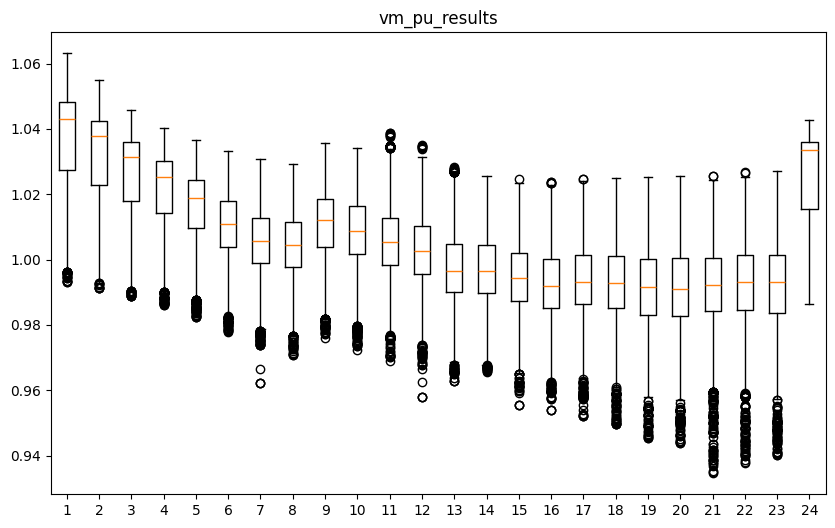

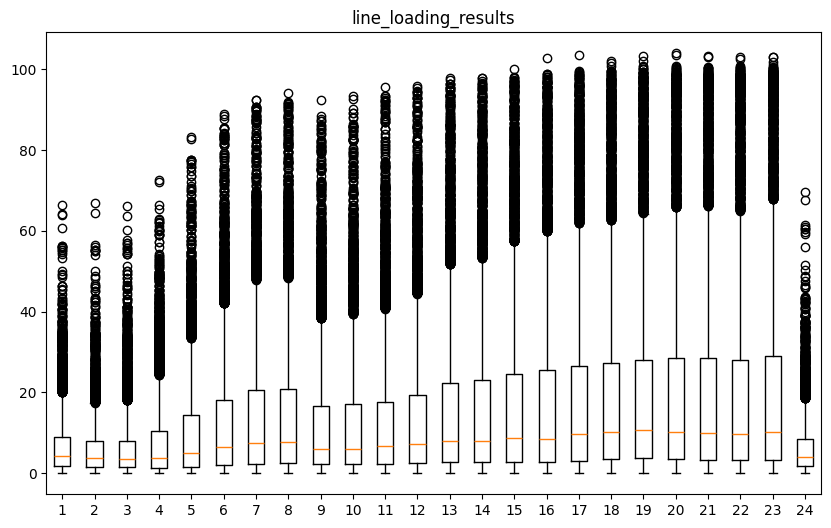

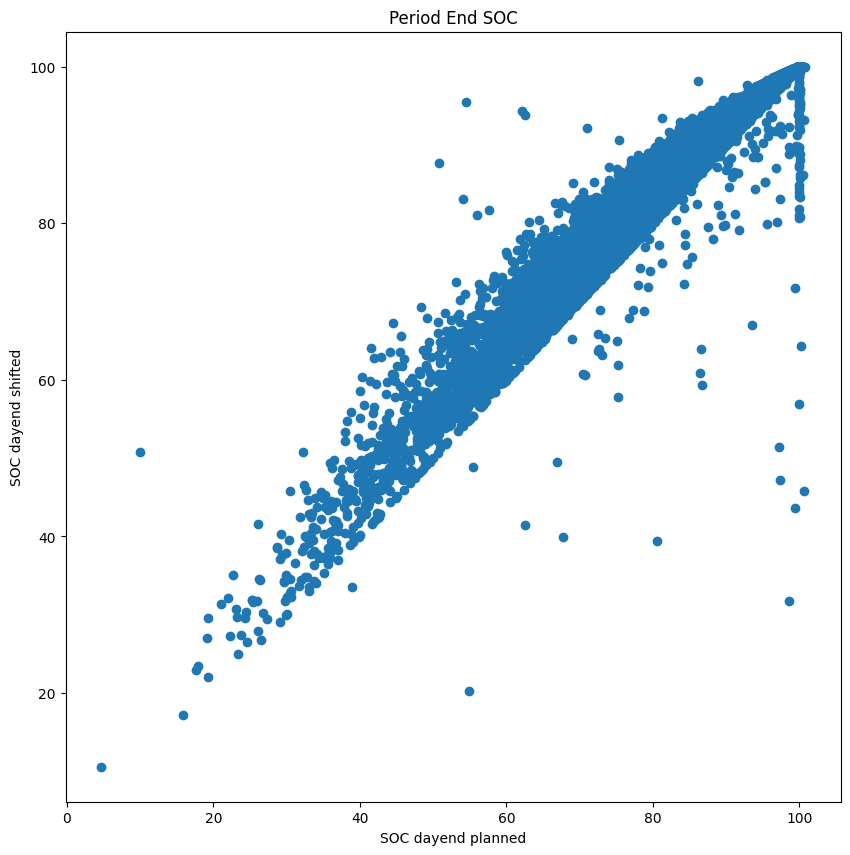

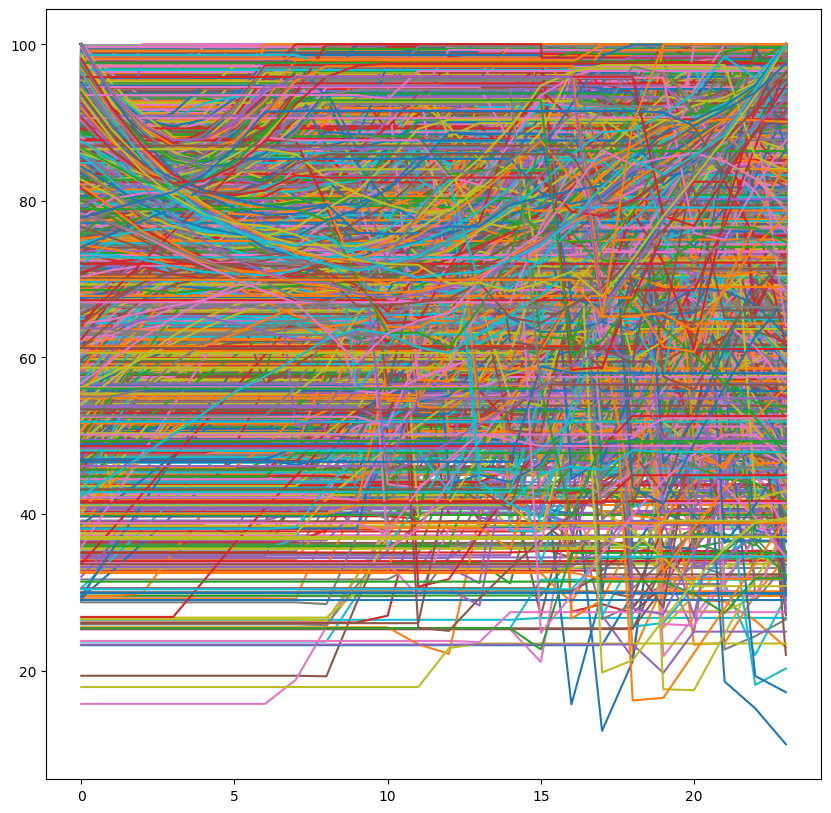

In [198]:
voltage = {(b,t):1+pyo.value(m.DELTA_V[b,t]) for b in m.BUS for t in m.T}
angle = {(b,t):pyo.value(m.ANG[b,t]) for b in m.BUS for t in m.T}
soe_data = {(person, t): pyo.value(m.SOE[person, t]) for person in m.EVBAT for t in m.T}
soe_df = pd.DataFrame.from_dict(soe_data, orient='index', columns=['SOE'])
soe_df.index = pd.MultiIndex.from_tuples(soe_df.index, names=['person', 'time'])
soe_df = soe_df.unstack(level='time')
soe_df.columns = soe_df.columns.get_level_values(1)
branch_slack = {(i,j):pyo.value(m.BRANCH_slack[i,j]) for (i,j) in m.BRANCH}
branch_slack_df = pd.DataFrame.from_dict(branch_slack,orient='index',columns=['branch_slack'])
branch_slack_df.to_csv(f"{path}/branch_slack_result.csv")

PBRANCH_data = {((i,j),t):pyo.value(m.PBRANCH[i,j,t]) for (i,j) in m.BRANCH for t in m.T}
PBRANCH_df = pd.DataFrame.from_dict(PBRANCH_data, orient='index')
PBRANCH_df.index = pd.MultiIndex.from_tuples(PBRANCH_df.index,names=['BRANCH','time'])
PBRANCH_df = PBRANCH_df.unstack(level='BRANCH')
PBRANCH_df.columns = PBRANCH_df.columns.get_level_values(1)
QBRANCH_data = {((i,j),t):pyo.value(m.QBRANCH[i,j,t]) for (i,j) in m.BRANCH for t in m.T}
QBRANCH_df = pd.DataFrame.from_dict(QBRANCH_data, orient='index')
QBRANCH_df.index = pd.MultiIndex.from_tuples(QBRANCH_df.index,names=['BRANCH','time'])
QBRANCH_df = QBRANCH_df.unstack(level='BRANCH')
QBRANCH_df.columns = QBRANCH_df.columns.get_level_values(1)

EVGEN_data = {(park,t):pyo.value(-m.EVGENP[park,person,arr_idx,end_idx,bus,t]) for (park,person,arr_idx,end_idx,bus) in m.PARK for t in m.T}
EVGEN_df = pd.DataFrame.from_dict(EVGEN_data, orient='index', columns=['EVGEN'])
EVGEN_df.index = pd.MultiIndex.from_tuples(EVGEN_df.index,names=['park','time'])
EVGEN_df = EVGEN_df.unstack(level='park')
EVGEN_df.columns = EVGEN_df.columns.get_level_values(1)
EVGEN_df.to_csv(f"{path}/EVGEN_result.csv")


PVGENP_data = {(pv,t):pyo.value(m.PVGENP[pv,bus,t]) for (pv,bus) in m.PV for t in m.T}
PVGENP_df = pd.DataFrame.from_dict(PVGENP_data, orient='index', columns=['PVGEN'])
PVGENP_df.index = pd.MultiIndex.from_tuples(PVGENP_df.index,names=['pv','time'])
PVGENP_df = PVGENP_df.unstack(level='pv')
PVGENP_df.columns = PVGENP_df.columns.get_level_values(1)
PVGENP_df.to_csv(f"{path}/PVGENP_result.csv")
PVGENQ_data = {(pv,t):pyo.value(m.PVGENQ[pv,bus,t]) for (pv,bus) in m.PV for t in m.T}
PVGENQ_df = pd.DataFrame.from_dict(PVGENQ_data, orient='index', columns=['PVGEN'])
PVGENQ_df.index = pd.MultiIndex.from_tuples(PVGENQ_df.index,names=['pv','time'])
PVGENQ_df = PVGENQ_df.unstack(level='pv')
PVGENQ_df.columns = PVGENQ_df.columns.get_level_values(1)
PVGENQ_df.to_csv(f"{path}/PVGENQ_result.csv")
PVGENMAX = pd.DataFrame(pv_load_profile.pv_P_daily.tolist()).T
PVRATIO = (PVGENP_df/PVGENMAX)*100
PVRATIO.to_csv(f"{path}/PV_ratio.csv")

vm_pu = pd.DataFrame()
line_loading = pd.DataFrame()
for t in range(monitor_hr):
    net.load.loc[net.load.category == 'base', 'p_mw'] = base_p.loc[t].values
    net.load.loc[net.load.category=='base','q_mvar'] = net.load.loc[net.load.category == 'base'].p_mw*np.tan(np.arccos(0.97))
    net.load.loc[net.load.category == 'hp', 'p_mw'] = hp_p.loc[t].values
    net.load.loc[net.load.category == 'hp', 'q_mvar'] = net.load.loc[net.load.category == 'hp'].p_mw*np.tan(np.arccos(0.97))
    net.sgen.loc[net.sgen.type=='PV','p_mw'] = PVGENP_df.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','q_mvar'] = PVGENQ_df.loc[t].values
    net.storage.loc[net.storage.type=='ev','p_mw'] = EVGEN_df.loc[t].values
    pp.runpp(net)
    pp.to_pickle(net,filename=f'{path}/{folder}_hour_{t}_acopf_res.p')
    vm_pu[t] = net.res_bus.vm_pu
    line_loading[t] = net.res_line.loading_percent
plt.figure(figsize=(10,6))
plt.boxplot(vm_pu)
plt.title('vm_pu_results')
plt.savefig(f'{path}/{folder}_vmpu_res_changed.jpg')

plt.figure(figsize=(10,6))   
plt.boxplot(line_loading)
plt.title('line_loading_results')
plt.savefig(f'{path}/{folder}_lineloading_res.jpg')

dayendsoe_df = pd.DataFrame(index=SOE_dayend_dict.keys())
dayendsoe_df['planned'] = SOE_dayend_dict.values()
dayendsoe_df['shifted'] = soe_df[23]
dayendsoe_df['cap'] = EVCAP_dict.values()
dayendsoe_df['plannedsoc'] = dayendsoe_df.planned/dayendsoe_df.cap*100
dayendsoe_df['shiftedsoc'] = dayendsoe_df.shifted/dayendsoe_df.cap*100
plt.figure(figsize=(10,10))
plt.scatter(dayendsoe_df.plannedsoc,dayendsoe_df.shiftedsoc)
plt.xlabel("SOC dayend planned")
plt.ylabel("SOC dayend shifted")
plt.title("Period End SOC")
plt.savefig(f'{path}/period_end_soc.png')

soc_df = soe_df.apply(lambda row:row/EVCAP_dict[row.name]*100,axis=1)
plt.figure(figsize=(10,10))
for person,profile in soc_df.iterrows():
    plt.plot(profile)
plt.show()
soc_df.to_csv(f"{path}/SOC_result.csv")

In [127]:
inflow_id = list(zip(net.line[(net.line.to_bus==247)].from_bus,net.line[(net.line.to_bus==247)].to_bus))
outflow_id = list(zip(net.line[(net.line.from_bus==247)].from_bus,net.line[(net.line.from_bus==247)].to_bus))
pv_id = net.sgen[net.sgen.bus==247].index
ev_id = net.storage[net.storage.bus==247].index
base_id = base_load_profile[base_load_profile.Bus==247].index
hp_id = hp_load_profile[hp_load_profile.Bus==247].index

In [128]:
PVGENP_df[pv_id].sum(axis=1)-EVGEN_df[ev_id].sum(axis=1)-base_p[base_id].sum(axis=1)-PBRANCH_df[outflow_id].sum(axis=1)+PBRANCH_df[inflow_id].sum(axis=1)

time
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
dtype: float64